Kaggle 대회 참가 튜토리얼 
== 
by Sun-il Kim, 2019-01-18


![JPEG](https://smist08.files.wordpress.com/2017/03/kaggle.jpg)

https://www.kaggle.com 에 회원가입을 진행합니다.


참고로 휴대폰번호는 한 번 인증하면 다시 쓸 수 없으니 조심하세요.

https://www.kaggle.com/c/LANL-Earthquake-Prediction/

해당 대회에 참가 신청을 진행합니다. 

https://www.kaggle.com/c/LANL-Earthquake-Prediction/data
    
이제 대회 참가를 위한 데이터를 전부 받아야 합니다.

- train.csv  => 트레이닝에 사용할 데이터입니다. 
- test.zip  => 나중에 테스트에 사용할 데이터입니다. 
- sample_sumbission.csv  => 제출에 사용할 포멧이 완벽한 CSV파일입니다. 

sample_subission.csv를 사용하여 데이터를 입력하고 sumbission.csv 파일을 만들게 됩니다. 

**Tensorflow-GPU 파일이 아니라 Python3 파일로 노트북을 만들어 주세요.**

1.데이터 불러오기
==

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [20]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import mean_absolute_error

In [3]:
# train.csv 파일을 노트북파일 옆에 두시면 됩니다. 

# 트레이닝 데이터를 train 변수에 넣습니다. 포멧을 적절하게 바꿉니다. 
# 이 부분은 따로 수정하지 않으셔도 됩니다.
train = pd.read_csv('./train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

2.데이터 전처리
==

In [4]:
# 트레이닝 데이터가 잘 들어왔는지 획인해 봅시다.
train.head()

# 데이터를 확인해보니, pandas가 소수점을 표시하지 않는 것을 확인할 수 있습니다.

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [5]:
# pandas가 모든 소수점을 표시하도록 합니다.
pd.options.display.precision = 15

In [6]:
train.head()

# 이제 모든 소수점이 표시됩니다.

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


>**acoustic_data 는 현재 일어나고 있는 진동 수치입니다.**


>**time_to_failure 는 0이되면 지진이 일어나는 순간입니다.**


- 때문에 time_to_failure가 점점 줄어들고 있음을 볼 수 있습니다.
- 이 두 데이터간의 상관관계를 구하여, 앞으로 언제/얼마나 지진이 일어날 지 예측하는 것 입니다.
- 이 데이터에는 총 지진이 11번 일어나는 것으로 알고있습니다.

In [7]:
# 아주 간단한 데이터 전처리를 진행합니다. 
# 평균, 표준편차, 최대값, 최소값. 

rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

# 처리된 데이터가 들어갈 데이터프레임을 만들어줍니다. 
X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min'])
# 예측할 결과가 들어갈 데이터프레임을 만들어줍니다. 
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

# 데이터를 처리하여 저장합니다. 
for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()

100%|██████████| 4194/4194 [00:04<00:00, 853.25it/s]


In [8]:
X_train.head()

# 전처리된 데이터를 살펴봅니다.

,ave,std,max,min
0,4.884113333333334,5.101089126891323,104.0,-98.0
1,4.725766666666667,6.588801819164257,181.0,-154.0
2,4.906393333333333,6.967373808828945,140.0,-106.0
3,4.902240000000000,6.922282112791032,197.0,-199.0
4,4.908720000000000,7.301085852684289,145.0,-126.0


In [9]:
# 계속하여 전처리를 진행합니다.
# 평균을 제거하고 단위 분산에 맞게 스케일링하여 표준화합니다. 

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [10]:
X_train_scaled

array([[ 1.4241405 , -0.17021358, -0.21819351,  0.19321819],
       [ 0.80571603,  0.00473402,  0.06393601, -0.01803727],
       [ 1.51115526,  0.0492522 , -0.0862888 ,  0.16303883],
       ...,
       [ 0.34265275, -0.39124963, -0.36841832,  0.4157909 ],
       [-0.21161721, -0.28084016, -0.25483371,  0.1969906 ],
       [-0.00415653, -0.37312925, -0.3647543 ,  0.31393559]])

3.데이터 분석
==

In [21]:
# 가장 간단한 선형 SVM 회귀분석으로 데이터를 분석해보겠습니다.
# 선형(linear)말고는 아직은 아무 하이퍼파라미터를 추가하지 않았습니다. 디폴트 분석입니다.
svm = svm.SVR(kernel='linear')

# ".fit" 이란 트레이닝과 같습니다.
# ".fit" 이 트레이닝되면 해당 모델로 ".predict()" 즉 예측하는 것 입니다.

svm.fit(X_train_scaled, y_train.values.flatten())
y_pred = svm.predict(X_train_scaled)

In [22]:
# 어떤 클래스로서 어떤 하이퍼파라미터를 가지고 있는지 확인해 봅시다.
print (svm)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)


- 지금까지 학습에서는 SVM을 직접 구현하였었으나, 
- 이처럼 scikit-learn라이브러리를 사용하면 아주 쉽게 한 줄로 처리됨을 볼 수 있습니다.


**힌트(?)**
- 추가 발전을 위해선 scikit-learn라이브러리를 직접 알아봐야 합니다. 
- 예를 들어 SVM은 https://scikit-learn.org/stable/modules/svm.html#svm-regression
- 위의 링크에서 자세히 설명되어 있습니다.
- 다른 종류의 SVM? 어떠한 하이퍼파라미터? 각 하이퍼파라미터를 얼만큼? 
- 이런 것들을 최소한 이해할 수 있게 금주의 학습이 있었습니다.

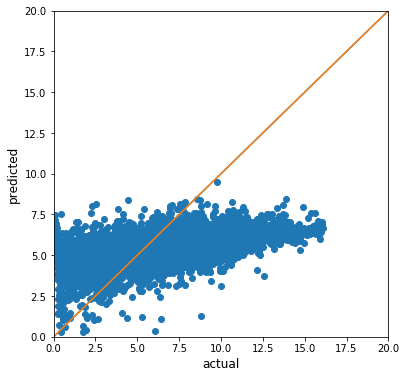

In [17]:
# matplotlib으로 그래프를 그려봅니다. 

plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [18]:
score = mean_absolute_error(y_train.values.flatten(), y_pred)
print(f'Score: {score:0.3f}')

Score: 2.808


## - 평균 에러를 구한 것이기 때문에, 낮으면 낮을수록 좋습니다. 
- 팁이라면, Kaggle에 실제로 제출하면 이것보다 더 좋게 나오기 때문에 
- 실제 순위는 훨씬 더 좋을 수 있습니다. 
- 이 예시만 해도 이미 기준 baseline보다 높아서 벌써 200위권일 듯 하네요?

4.Kaggle에 결과 제출
==

- 먼저 sample_submssion.csv 파일을 노트북 파일 옆에 가져다둡니다.
- 이 파일을 기반으로 제출할 파일을 만들게 됩니다.


과정이 살짝 이해가 어려울 수 있습니다. 지금까지의 진행은 이렇게 된것입니다.
>1. train.csv를 사용하여 데이터를 전처리하고
2. "svm" 클레스 안에 .fit을 사용하여 트레이닝을 마쳐두었습니다. 
3. 이후 트레이닝 데이터에서 최적화가 완료되면 

밑의 과정은,


>4. test.csv파일들을 데려와 똑같은 데이터프레임을 만들고 
5. "svm" 클레스 안에 들어있는 이미 훈련된 알고리즘을 가지고 
6. 예상 submission.csv 를 만드는 것입니다.
7. 그리고 케글에서 그 정확도를 판단합니다. 

In [48]:
# sample_submission을 토데로 정해진 포멧을 가져옵니다.
submission = pd.read_csv('./sample_submission.csv', index_col='seg_id')

- test.zip 파일 역시 압축을 풀어서, 폴더 통으로 노트북 파일 옆에 가져다둡니다.

In [50]:
# 테스트 데이터가 들어갈 데이터프레임을 만들어둡니다.
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [51]:
# 테스트 데이터를 트레이닝데이터와 똑같이 처리하여 저장해둡니다. 
for seg_id in X_test.index:
    seg = pd.read_csv('./test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()

In [52]:
# 테스트 데이터를 트레이닝데이터와 똑같이 처리하여 저장해둡니다. (2)
X_test_scaled = scaler.transform(X_test)

# "svm" 클레스 안에 훈련된 알고리즘을 테스트 데이터에 적용시켜봅니다.
submission['time_to_failure'] = svm.predict(X_test_scaled)

# 테스트 데이터의 훈련 결과를 submission.csv 파일에 저장합니다.
submission.to_csv('submission.csv')

- 이제 노트북의 위치에 submission.csv 파일이 생성되었습니다.
- 이 파일을, https://www.kaggle.com/c/LANL-Earthquake-Prediction/submit
- 해당 링크에 제출하면 완료!


- 등수를 카톡에 자랑해 보세요.

**힌트(?)**
- Kaggle 제출은 하루 2번 밖에 되지 않습니다. (아침9시초기화)